In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import pandas as pd
from sklearn import linear_model, preprocessing
#from sklearnex import patch_sklearn
#patch_sklearn()
from patsy import dmatrices, dmatrix
import copy
import re
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import math as m
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
reg_seas_by_year = pd.read_csv('C:/Users/Chris Li/Documents/UC Davis/STA 221/Data/player_regular_season.txt', sep = ',') 
positions = pd.read_csv('C:/Users/Chris Li/Documents/UC Davis/STA 221/Data/players.txt', sep = ',') 
positions = positions[['ilkid', 'position']]

In [4]:
# filter to 1979 and after, 3 point line was adopted. so we can use three point data
# year 1979 represent 79-80 season
# also data was sparse early on

# add some helpful variables
later_data = reg_seas_by_year[reg_seas_by_year.apply(lambda x: (x['year'] >= 1979), axis=1)].copy()

later_data = later_data.\
    sort_values(['year', 'ilkid'], ascending=[True, True])
later_data['cum_gp'] = later_data.groupby(['ilkid'])['gp'].cumsum()
later_data['career_gp'] = later_data.groupby(['ilkid'])['gp'].transform('sum')
later_data['season_num'] = later_data.groupby(['ilkid'])['gp'].cumcount()+1

# only say yes if over 100 for that whole season
later_data["lag_cum_gp"] = later_data.groupby('ilkid')['cum_gp'].shift(1)

later_data['season_num_if_not_100_by_beg_seas'] = np.where(later_data['lag_cum_gp'] >= 100, 0, later_data['season_num'])
later_data['seasons_to_100'] = later_data.groupby(['ilkid'])['season_num_if_not_100_by_beg_seas'].transform('max')
later_data['total_seasons'] = later_data.groupby(['ilkid'])['season_num'].transform('max')

later_data['gp_if_in_first3seas'] = np.where(later_data['season_num'] <= 3, later_data['gp'], 0)
later_data['first_three_seas_gp'] = later_data.groupby(['ilkid'])['gp_if_in_first3seas'].transform('sum')

later_data['gp_after_first3seas'] = np.where(later_data['season_num'] > 3, later_data['gp'], 0)
later_data['after_first_three_seas_gp'] = later_data.groupby(['ilkid'])['gp_after_first3seas'].transform('sum')
later_data['maxseasgp_after_first_three_seas'] = later_data.groupby(['ilkid'])['gp_after_first3seas'].transform('max')

pg_vars = ['minutes', 'pts', 'oreb', 'dreb', 'reb', 'asts', 'stl', 'blk',
       'turnover', 'pf']

# make per game variables
for var in pg_vars:
    later_data[var + "_pg"] = later_data[var] / later_data['gp']

later_data = later_data.assign(fg_pct = lambda x: x.fgm / x.fga,
                              ft_pct = lambda x: x.ftm / x.fta,
                              tp_pct = lambda x: x.tpm / x.tpa)
    

In [5]:
# filter to players that played more than 20 games in first three seasons and at least one game afterwards
relevant_players = later_data[later_data.apply(lambda x: (x['first_three_seas_gp'] >= 20) & (x['after_first_three_seas_gp'] >= 1), axis=1)].copy()
#relevant_players.head()

In [6]:
# this will be dataset used for analysis
players_to_cluster = relevant_players.copy()

## 1. Make final dataset for first 3 seasons

In [7]:
print("Number of Players")
len(players_to_cluster['ilkid'].drop_duplicates())

Number of Players


1116

In [8]:
# make first three seasons dataset - wide version, one row for each player

first_3_seas = players_to_cluster[players_to_cluster.apply(lambda x: (x['season_num'] <= 3), axis=1)].copy()

first_3_seas = pd.pivot(first_3_seas, values = ['gp','minutes_pg', 'pts_pg', 'oreb_pg', 'dreb_pg', 'reb_pg', 'asts_pg',
       'stl_pg', 'blk_pg', 'turnover_pg', 'pf_pg', 'fg_pct', 'ft_pct','tpa', 'tpm', \
       'tp_pct'], index = ['ilkid', 'firstname', 'lastname', 'career_gp', \
        'total_seasons'], columns = 'season_num').reset_index()

level_one = first_3_seas.columns.get_level_values(0).astype(str)
level_two = first_3_seas.columns.get_level_values(1).astype(str)
first_3_seas.columns = level_one + level_two

first_3_seas.head(5)

# filter out pl;ayers with data that have missing values for non three point categories
first_3_seas = first_3_seas.dropna(subset=list(set(first_3_seas.columns) - set(["tp_pct1", "tp_pct2", "tp_pct3"])))
    
# IMPUTE VALUES for three point percentage. This was just testing, these variables are never used in analyses
# impute values for missing three point pct as weighted averages
mean_tp1 = first_3_seas.loc[:, 'tpm1'].sum() / first_3_seas.loc[:, 'tpa1'].sum()
mean_tp1

mean_tp2 = first_3_seas.loc[:, 'tpm2'].sum() / first_3_seas.loc[:, 'tpa2'].sum()
mean_tp2

mean_tp3 = first_3_seas.loc[:, 'tpm3'].sum() / first_3_seas.loc[:, 'tpa3'].sum()
mean_tp3

# print how many players have na three point pct in each of first three seasons
print(sum(np.where(first_3_seas['tp_pct1'].isna(), 1, 0)))
print(sum(np.where(first_3_seas['tp_pct2'].isna(), 1, 0)))
print(sum(np.where(first_3_seas['tp_pct3'].isna(), 1, 0)))

first_3_seas['tp_pct1'] = np.where(first_3_seas['tp_pct1'].isna(), mean_tp1, first_3_seas['tp_pct1'])
first_3_seas['tp_pct2'] = np.where(first_3_seas['tp_pct2'].isna(), mean_tp2, first_3_seas['tp_pct2'])
first_3_seas['tp_pct3'] = np.where(first_3_seas['tp_pct3'].isna(), mean_tp3, first_3_seas['tp_pct3'])

180
159
172


In [9]:
print("Number of Players")
len(first_3_seas['ilkid'].drop_duplicates())

Number of Players


1041

less than 10% of data is filtered out for cleaning steps

In [10]:
# confirm there are no na values
#first_3_seas.isna().sum()

In [11]:
# merge positions onto data
final_pre_data = first_3_seas[list(set(first_3_seas.columns) - set(["tpa1", "tpa2", "tpa3","tpm1", "tpm2", "tpm3"]))].copy().reset_index()
final_pre_data = pd.merge(final_pre_data, positions, on='ilkid', how='left')

# confirm all rows have positions
final_pre_data['position'].isna().sum()

0

## 2. Make a player level dataset which aggregates all a player's statistics from after their first three seasons

In [12]:
# filter to seasons after third season
post_data_unrestr = players_to_cluster[players_to_cluster.apply(lambda x: (x['season_num'] > 3), axis=1)].copy()
pre_players = final_pre_data['ilkid'].drop_duplicates()

# aggregate data
post_player_level = post_data_unrestr.groupby(['ilkid'])[['gp',
       'minutes', 'pts', 'oreb', 'dreb', 'reb', 'asts', 'stl', 'blk',
       'turnover', 'pf', 'fga', 'fgm', 'fta', 'ftm', 'tpa', 'tpm']].sum().reset_index()

# inner join to get rid of players filtered out in pre data cleaning
post_player_level = pd.merge(pre_players, post_player_level, on='ilkid', how='left')

In [13]:
# get percentage measures
post_temp1 = copy.copy(post_player_level).assign(fg_pct = lambda x: x.fgm / x.fga,
                              ft_pct = lambda x: x.ftm / x.fta,
                              tp_pct = lambda x: x.tpm / x.tpa)

# get per game numbers
for var in list(set(post_temp1.columns) - set(['ilkid','gp', 'fga', 'fgm',
       'fta', 'ftm', 'tpa', 'tpm', 'fg_pct', 'ft_pct', 'tp_pct'])):
    post_temp1[var] = post_temp1[var] / post_temp1['gp']

# drop players that have na values in any columns
post_temp1 = post_temp1.dropna(subset=list(set(post_temp1.columns) - set(["tp_pct"])))

In [14]:
# any nas
#post_temp1.isna().sum()


na values for tp pct is okay, not used in any analyses

#### Impute missing values for three point percentage - but this variable is not used in final analysis

In [15]:
# impute values for missing three point pct as weighted averages, not used in any analyses
post_final = copy.copy(post_temp1)

mean_tp = post_final.loc[:, 'tpm'].sum() / post_final.loc[:, 'tpa'].sum()

post_final['tp_pct'] = np.where(post_final['tp_pct'].isna(), mean_tp, post_final['tp_pct'])

# merge on positions
post_final = pd.merge(post_final, positions, on='ilkid', how='left')

# confirm all players have positions
post_final['position'].isna().sum()

0

In [16]:
# make dataset for guards
post_final_guard = post_final[post_final.apply(lambda x: (x['position'] == 'G'), axis=1)].copy()

# get post guard ids to join back to pre data
post_guard_ids = post_final_guard[['ilkid']]

post_final_guard = post_final_guard[list(set(post_final.columns) - set(['fga', 'fgm',
       'fta', 'ftm', 'tpa', 'tpm', 'ilkid', 'firstname', 'lastname']))]

In [17]:

# make dataset for forwards
post_final_forw = post_final[post_final.apply(lambda x: (x['position'] != 'G'), axis=1)].copy()

# get post forward ids to join back to pre data
post_forw_ids = post_final_forw[['ilkid']]

post_final_forw = post_final_forw[list(set(post_final.columns) - set(['fga', 'fgm',
       'fta', 'ftm', 'tpa', 'tpm', 'ilkid', 'firstname', 'lastname']))]

## 3. GMM - Guards

In [18]:
# filter to variables to cluster on
post_array_off_guard = post_final_guard[['pts','asts','reb','minutes']].to_numpy()

In [19]:
from sklearn.mixture import GaussianMixture
GM_guard = GaussianMixture(n_components=3, random_state=0)
GM_guard.fit(post_array_off_guard)

GM_predict_guard = GM_guard.predict(post_array_off_guard)

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Cluster means for 'pts','asts','reb','minutes'

In [20]:
GM_guard.means_

array([[ 9.33508491,  3.14171936,  2.38182651, 23.30532677],
       [16.83849834,  5.18383793,  4.00510457, 34.17180995],
       [ 4.66822725,  1.87471487,  1.36206125, 13.9916336 ]])

In [21]:
clusters_guard = GM_predict_guard.copy()

### Cross Validation and BIC

In [26]:
# find optimal number of clusters
OMP_NUM_THREADS=2
test_score_list = []
bic_list = []
# loop over different train test splits
for k in range(0,10):
    post_tr,post_te = train_test_split(post_array_off_guard, test_size = 0.2, train_size = 0.8, random_state = k)
    # loop over random states

    cluster_scores = []
    bics=[]
    for i in range(2,11):
        gm = GaussianMixture(n_components=i, random_state=i)
        gm.fit(post_tr)
        # likelihood of test data
        cluster_scores.append(m.e**(gm.score(post_te)))
        bics.append(gm.bic(post_te))
    test_score_list.append(cluster_scores)
    bic_list.append(bics)

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known

In [23]:
avg_likeli = np.array(test_score_list).mean(axis = 0)
avg_likeli

array([0.00032645, 0.00035644, 0.00037167, 0.00035578, 0.00034176,
       0.00032523, 0.00029784, 0.00030451, 0.00027325])

In [28]:
cluster_scores = []
bics=[]
for j in range(2,11):
    # loop over number of clusters
    
    gm = GaussianMixture(n_components=j, random_state=j)
    gm.fit(post_array_off_guard)
    # likelihood of test data
    cluster_scores.append(m.e**(gm.score(post_array_off_guard)))
    bics.append(gm.bic(post_array_off_guard))

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known

In [29]:
bics

[6791.284150121421,
 6766.553769757378,
 6746.664454436617,
 6854.436344724365,
 6894.80107133367,
 6967.194400559898,
 7019.337547094699,
 7046.35872975953,
 7083.388401239557]

## 4. GMM - Forward

In [30]:
# filter to variables to cluster on
post_array_off_forw = post_final_forw[['pts','asts','reb','minutes']].to_numpy()

In [31]:
GM_forw = GaussianMixture(n_components=3, random_state=0)
GM_forw.fit(post_array_off_forw)

GM_predict_forw = GM_forw.predict(post_array_off_forw)

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Cluster means for 'pts','asts','reb','minutes'

In [32]:
GM_forw.means_

array([[ 3.54761498,  0.44634173,  2.58207098, 11.39142058],
       [ 7.7921213 ,  1.17986446,  4.62077351, 20.92530354],
       [15.17807524,  2.45627661,  6.94161229, 31.19296452]])

In [33]:
clusters_forw = GM_predict_forw.copy()

### Cross Validation and BIC

In [36]:
# find optimal number of clusters

test_score_list2 = []
bic_list2 = []
# loop over different train test splits
for k in range(0,10):
    post_tr,post_te = train_test_split(post_array_off_forw, test_size = 0.2, train_size = 0.8, random_state = k)
    # loop over random states

    cluster_scores = []
    bics=[]
    for i in range(2,11):
        gm = GaussianMixture(n_components=i, random_state=i)
        gm.fit(post_tr)
        # likelihood of test data
        cluster_scores.append(m.e**(gm.score(post_te)))
        bics.append(gm.bic(post_te))
    test_score_list2.append(cluster_scores)
    bic_list2.append(bics)

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known

In [37]:
avg_likeli2 = np.array(test_score_list2).mean(axis = 0)
avg_likeli2

array([0.00046614, 0.00052959, 0.00054482, 0.00053846, 0.00054573,
       0.00053076, 0.00051293, 0.00049671, 0.0004795 ])

In [40]:
cluster_scores2 = []
bics2=[]
for j in range(2,11):
    # loop over number of clusters
    
    gm = GaussianMixture(n_components=j, random_state=j)
    gm.fit(post_array_off_forw)
    # likelihood of test data
    cluster_scores2.append(m.e**(gm.score(post_array_off_forw)))
    bics2.append(gm.bic(post_array_off_forw))

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known

In [41]:
bics2

[9704.40152091802,
 9571.455869033633,
 9581.476099450627,
 9635.954241709624,
 9697.09836250684,
 9774.335600340055,
 9866.090407887812,
 9912.760593590434,
 9962.299626952186]

## 5. Standardize Data for first three seasons

In [42]:
# make sure set of players in first three seasons data and after first three seasons data is the same
final_pre_data_tf = pd.merge(post_final['ilkid'],final_pre_data, on='ilkid', how='left').reset_index()

In [43]:
final_pre_data_guard = final_pre_data_tf[final_pre_data_tf.apply(lambda x: (x['position'] == 'G'), axis=1)].copy()
print(final_pre_data_guard.shape)
final_pre_data_forw = final_pre_data_tf[final_pre_data_tf.apply(lambda x: (x['position'] != 'G'), axis=1)].copy()
print(final_pre_data_forw.shape)

(412, 50)
(622, 50)


In [44]:
# filter to variables to use for prediction
# dont use three point data

final_pre_data_guard_tf = final_pre_data_guard[['asts_pg1', 'asts_pg2', 'asts_pg3',
 'blk_pg1', 'blk_pg2', 'blk_pg3',
 'fg_pct1', 'fg_pct2', 'fg_pct3',
 'ft_pct1', 'ft_pct2', 'ft_pct3',
 'gp1', 'gp2', 'gp3',
 'minutes_pg1', 'minutes_pg2', 'minutes_pg3',
 'pf_pg1', 'pf_pg2', 'pf_pg3',
 'pts_pg1', 'pts_pg2', 'pts_pg3',
 'reb_pg1', 'reb_pg2', 'reb_pg3',
 'stl_pg1', 'stl_pg2', 'stl_pg3',
 'turnover_pg1', 'turnover_pg2', 'turnover_pg3']].to_numpy()

In [45]:
# split guards and standardize
pre_tr_guard,pre_te_guard, clust_tr_guard, clust_te_guard = train_test_split(final_pre_data_guard_tf, \
                    clusters_guard, test_size = 0.3, train_size = 0.7, random_state = 2)

scaler_guard = StandardScaler()
scaler_guard.fit(pre_tr_guard)

pre_tr_guard = scaler_guard.transform(pre_tr_guard)

pre_te_guard = scaler_guard.transform(pre_te_guard)

In [46]:
# filter to variables to use for prediction
# dont use three point data

final_pre_data_forw_tf = final_pre_data_forw[['asts_pg1', 'asts_pg2', 'asts_pg3',
 'blk_pg1', 'blk_pg2', 'blk_pg3',
 'fg_pct1', 'fg_pct2', 'fg_pct3',
 'ft_pct1', 'ft_pct2', 'ft_pct3',
 'gp1', 'gp2', 'gp3',
 'minutes_pg1', 'minutes_pg2', 'minutes_pg3',
 'pf_pg1', 'pf_pg2', 'pf_pg3',
 'pts_pg1', 'pts_pg2', 'pts_pg3',
 'reb_pg1', 'reb_pg2', 'reb_pg3',
 'stl_pg1', 'stl_pg2', 'stl_pg3',
 'turnover_pg1', 'turnover_pg2', 'turnover_pg3']].to_numpy()

In [400]:
#len(clusters_forw)

In [399]:
#final_pre_data_forw.head()

In [47]:
# split forws and standardize
pre_tr_forw, pre_te_forw, clust_tr_forw, clust_te_forw = train_test_split(final_pre_data_forw_tf, \
                    clusters_forw, test_size = 0.3, train_size = 0.7, random_state = 2)

scaler_forw = StandardScaler()
scaler_forw.fit(pre_tr_forw)

pre_tr_forw = scaler_forw.transform(pre_tr_forw)

pre_te_forw = scaler_forw.transform(pre_te_forw)

In [401]:
#len(final_pre_data_forw_tf.columns)

## 6. Tensorflow - Neural Networks

### Fitting and Predicting for Guards 
#### Testing different layers

In [355]:
## 3
model_guard3 = Sequential()
model_guard3.add(Flatten(input_shape=(pre_tr_guard.shape[1],)))
model_guard3.add(Dense(3, activation='relu'))
model_guard3.add(Dropout(0.3))
model_guard3.add(Dense(3, activation='softmax'))
model_guard3.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_guard3 = model_guard3.fit(pre_tr_guard, clust_tr_guard, batch_size=50, epochs=50 ,verbose=0)
predictions_guard3 = model_guard3.predict(pre_te_guard)

max_prob_indices_guard3 = predictions_guard3.argmax(axis = 1)
conf_matrix_guard3 = confusion_matrix(clust_te_guard, max_prob_indices_guard3)
print(model_guard3.summary())
np.trace(conf_matrix_guard3)/len(clust_te_guard)

4/4 [==============================] - 0s 6ms/step
Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_100 (Flatten)       (None, 33)                0         
                                                                 
 dense_200 (Dense)           (None, 3)                 102       
                                                                 
 dropout_100 (Dropout)       (None, 3)                 0         
                                                                 
 dense_201 (Dense)           (None, 3)                 12        
                                                                 
Total params: 114 (456.00 Byte)
Trainable params: 114 (456.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


0.5967741935483871

In [354]:
## 4
model_guard4 = Sequential()
model_guard4.add(Flatten(input_shape=(pre_tr_guard.shape[1],)))
model_guard4.add(Dense(4, activation='relu'))
model_guard4.add(Dropout(0.3))
model_guard4.add(Dense(3, activation='softmax'))
model_guard4.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_guard4 = model_guard4.fit(pre_tr_guard, clust_tr_guard, batch_size=50, epochs=50 ,verbose=0)
predictions_guard4 = model_guard4.predict(pre_te_guard)

max_prob_indices_guard4 = predictions_guard4.argmax(axis = 1)
conf_matrix_guard4 = confusion_matrix(clust_te_guard, max_prob_indices_guard4)
print(model_guard4.summary())
np.trace(conf_matrix_guard4)/len(clust_te_guard)

4/4 [==============================] - 0s 5ms/step
Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_99 (Flatten)        (None, 33)                0         
                                                                 
 dense_198 (Dense)           (None, 4)                 136       
                                                                 
 dropout_99 (Dropout)        (None, 4)                 0         
                                                                 
 dense_199 (Dense)           (None, 3)                 15        
                                                                 
Total params: 151 (604.00 Byte)
Trainable params: 151 (604.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


0.5887096774193549

In [364]:
## 5
model_guard5 = Sequential()
model_guard5.add(Flatten(input_shape=(pre_tr_guard.shape[1],)))
model_guard5.add(Dense(5, activation='relu'))
model_guard5.add(Dropout(0.3))
model_guard5.add(Dense(3, activation='softmax'))
model_guard5.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_guard5 = model_guard5.fit(pre_tr_guard, clust_tr_guard, batch_size=50, epochs=50 ,verbose=0)
predictions_guard5 = model_guard5.predict(pre_te_guard)

max_prob_indices_guard5 = predictions_guard5.argmax(axis = 1)
conf_matrix_guard5 = confusion_matrix(clust_te_guard, max_prob_indices_guard5)
print(model_guard5.summary())
np.trace(conf_matrix_guard5)/len(clust_te_guard)

4/4 [==============================] - 0s 3ms/step
Model: "sequential_106"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_106 (Flatten)       (None, 33)                0         
                                                                 
 dense_212 (Dense)           (None, 5)                 170       
                                                                 
 dropout_106 (Dropout)       (None, 5)                 0         
                                                                 
 dense_213 (Dense)           (None, 3)                 18        
                                                                 
Total params: 188 (752.00 Byte)
Trainable params: 188 (752.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


0.6290322580645161

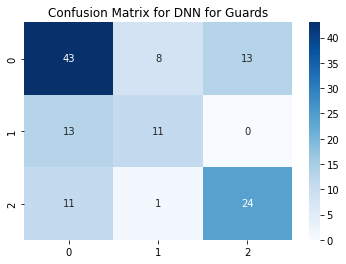

In [365]:
ax = sns.heatmap(conf_matrix_guard5, annot=True, fmt="d", cmap="Blues")
ax.set_title("Confusion Matrix for DNN for Guards");

In [352]:
## 6
model_guard6 = Sequential()
model_guard6.add(Flatten(input_shape=(pre_tr_guard.shape[1],)))
model_guard6.add(Dense(6, activation='relu'))
model_guard6.add(Dropout(0.3))
model_guard6.add(Dense(3, activation='softmax'))
model_guard6.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_guard6 = model_guard6.fit(pre_tr_guard, clust_tr_guard, batch_size=50, epochs=50 ,verbose=0)
predictions_guard6 = model_guard6.predict(pre_te_guard)

max_prob_indices_guard6 = predictions_guard6.argmax(axis = 1)
conf_matrix_guard6 = confusion_matrix(clust_te_guard, max_prob_indices_guard6)
print(model_guard6.summary())
np.trace(conf_matrix_guard6)/len(clust_te_guard)

4/4 [==============================] - 0s 4ms/step
Model: "sequential_97"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_97 (Flatten)        (None, 33)                0         
                                                                 
 dense_194 (Dense)           (None, 6)                 204       
                                                                 
 dropout_97 (Dropout)        (None, 6)                 0         
                                                                 
 dense_195 (Dense)           (None, 3)                 21        
                                                                 
Total params: 225 (900.00 Byte)
Trainable params: 225 (900.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


0.5725806451612904

In [350]:
## 7
model_guard7 = Sequential()
model_guard7.add(Flatten(input_shape=(pre_tr_guard.shape[1],)))
model_guard7.add(Dense(7, activation='relu'))
model_guard7.add(Dropout(0.3))
model_guard7.add(Dense(3, activation='softmax'))
model_guard7.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_guard7 = model_guard7.fit(pre_tr_guard, clust_tr_guard, batch_size=50, epochs=50 ,verbose=0)
predictions_guard7 = model_guard7.predict(pre_te_guard)

max_prob_indices_guard7 = predictions_guard7.argmax(axis = 1)
conf_matrix_guard7 = confusion_matrix(clust_te_guard, max_prob_indices_guard7)
print(model_guard7.summary())
np.trace(conf_matrix_guard7)/len(clust_te_guard)

4/4 [==============================] - 0s 3ms/step
Model: "sequential_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_95 (Flatten)        (None, 33)                0         
                                                                 
 dense_190 (Dense)           (None, 7)                 238       
                                                                 
 dropout_95 (Dropout)        (None, 7)                 0         
                                                                 
 dense_191 (Dense)           (None, 3)                 24        
                                                                 
Total params: 262 (1.02 KB)
Trainable params: 262 (1.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


0.5564516129032258

In [347]:
## 8
model_guard8 = Sequential()
model_guard8.add(Flatten(input_shape=(pre_tr_guard.shape[1],)))
model_guard8.add(Dense(8, activation='relu'))
model_guard8.add(Dropout(0.3))
model_guard8.add(Dense(3, activation='softmax'))
model_guard8.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_guard8 = model_guard8.fit(pre_tr_guard, clust_tr_guard, batch_size=50, epochs=50 ,verbose=0)
predictions_guard8 = model_guard8.predict(pre_te_guard)

max_prob_indices_guard8 = predictions_guard8.argmax(axis = 1)
conf_matrix_guard8 = confusion_matrix(clust_te_guard, max_prob_indices_guard8)
print(model_guard8.summary())
np.trace(conf_matrix_guard8)/len(clust_te_guard)

4/4 [==============================] - 0s 4ms/step
Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_92 (Flatten)        (None, 33)                0         
                                                                 
 dense_184 (Dense)           (None, 8)                 272       
                                                                 
 dropout_92 (Dropout)        (None, 8)                 0         
                                                                 
 dense_185 (Dense)           (None, 3)                 27        
                                                                 
Total params: 299 (1.17 KB)
Trainable params: 299 (1.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


0.5161290322580645

### Forwards

In [325]:
## 3
model_forw3 = Sequential()
model_forw3.add(Flatten(input_shape=(pre_tr_forw.shape[1],)))
model_forw3.add(Dense(3, activation='relu'))
model_forw3.add(Dropout(0.3))
model_forw3.add(Dense(3, activation='softmax'))
model_forw3.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_forw3 = model_forw3.fit(pre_tr_forw, clust_tr_forw, batch_size=50, epochs=50 ,verbose=0)
predictions_forw3 = model_forw3.predict(pre_te_forw)

max_prob_indices_forw3 = predictions_forw3.argmax(axis = 1)
conf_matrix_forw3 = confusion_matrix(clust_te_forw, max_prob_indices_forw3)
print(model_forw3.summary())
np.trace(conf_matrix_forw3)/len(clust_te_forw)

6/6 [==============================] - 0s 2ms/step
Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_82 (Flatten)        (None, 33)                0         
                                                                 
 dense_164 (Dense)           (None, 3)                 102       
                                                                 
 dropout_82 (Dropout)        (None, 3)                 0         
                                                                 
 dense_165 (Dense)           (None, 3)                 12        
                                                                 
Total params: 114 (456.00 Byte)
Trainable params: 114 (456.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


0.5668449197860963

In [326]:
## 4
model_forw4 = Sequential()
model_forw4.add(Flatten(input_shape=(pre_tr_forw.shape[1],)))
model_forw4.add(Dense(4, activation='relu'))
model_forw4.add(Dropout(0.3))
model_forw4.add(Dense(3, activation='softmax'))
model_forw4.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_forw4 = model_forw4.fit(pre_tr_forw, clust_tr_forw, batch_size=50, epochs=50 ,verbose=0)
predictions_forw4 = model_forw4.predict(pre_te_forw)

max_prob_indices_forw4 = predictions_forw4.argmax(axis = 1)
conf_matrix_forw4 = confusion_matrix(clust_te_forw, max_prob_indices_forw4)
print(model_forw4.summary())
np.trace(conf_matrix_forw4)/len(clust_te_forw)

6/6 [==============================] - 0s 3ms/step
Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_83 (Flatten)        (None, 33)                0         
                                                                 
 dense_166 (Dense)           (None, 4)                 136       
                                                                 
 dropout_83 (Dropout)        (None, 4)                 0         
                                                                 
 dense_167 (Dense)           (None, 3)                 15        
                                                                 
Total params: 151 (604.00 Byte)
Trainable params: 151 (604.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


0.5721925133689839

In [327]:
## 5
model_forw5 = Sequential()
model_forw5.add(Flatten(input_shape=(pre_tr_forw.shape[1],)))
model_forw5.add(Dense(5, activation='relu'))
model_forw5.add(Dropout(0.3))
model_forw5.add(Dense(3, activation='softmax'))
model_forw5.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_forw5 = model_forw5.fit(pre_tr_forw, clust_tr_forw, batch_size=50, epochs=50 ,verbose=0)
predictions_forw5 = model_forw5.predict(pre_te_forw)

max_prob_indices_forw5 = predictions_forw5.argmax(axis = 1)
conf_matrix_forw5 = confusion_matrix(clust_te_forw, max_prob_indices_forw5)
print(model_forw5.summary())
np.trace(conf_matrix_forw5)/len(clust_te_forw)

6/6 [==============================] - 0s 3ms/step
Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_84 (Flatten)        (None, 33)                0         
                                                                 
 dense_168 (Dense)           (None, 5)                 170       
                                                                 
 dropout_84 (Dropout)        (None, 5)                 0         
                                                                 
 dense_169 (Dense)           (None, 3)                 18        
                                                                 
Total params: 188 (752.00 Byte)
Trainable params: 188 (752.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


0.6149732620320856

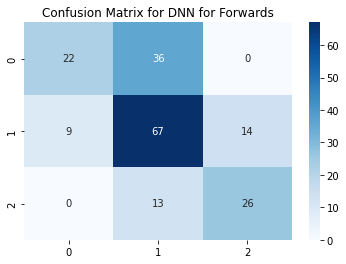

In [359]:
ax = sns.heatmap(conf_matrix_forw5, annot=True, fmt="d", cmap="Blues")
ax.set_title("Confusion Matrix for DNN for Forwards");

In [328]:
## 6
model_forw6 = Sequential()
model_forw6.add(Flatten(input_shape=(pre_tr_forw.shape[1],)))
model_forw6.add(Dense(6, activation='relu'))
model_forw6.add(Dropout(0.3))
model_forw6.add(Dense(3, activation='softmax'))
model_forw6.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_forw6 = model_forw6.fit(pre_tr_forw, clust_tr_forw, batch_size=50, epochs=50 ,verbose=0)
predictions_forw6 = model_forw6.predict(pre_te_forw)

max_prob_indices_forw6 = predictions_forw6.argmax(axis = 1)
conf_matrix_forw6 = confusion_matrix(clust_te_forw, max_prob_indices_forw6)
print(model_forw6.summary())
np.trace(conf_matrix_forw6)/len(clust_te_forw)

6/6 [==============================] - 0s 4ms/step
Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_85 (Flatten)        (None, 33)                0         
                                                                 
 dense_170 (Dense)           (None, 6)                 204       
                                                                 
 dropout_85 (Dropout)        (None, 6)                 0         
                                                                 
 dense_171 (Dense)           (None, 3)                 21        
                                                                 
Total params: 225 (900.00 Byte)
Trainable params: 225 (900.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


0.5614973262032086

In [339]:
## 7
model_forw7 = Sequential()
model_forw7.add(Flatten(input_shape=(pre_tr_forw.shape[1],)))
model_forw7.add(Dense(7, activation='relu'))
model_forw7.add(Dropout(0.3))
model_forw7.add(Dense(3, activation='softmax'))
model_forw7.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_forw7 = model_forw7.fit(pre_tr_forw, clust_tr_forw, batch_size=50, epochs=50 ,verbose=0)
predictions_forw7 = model_forw7.predict(pre_te_forw)

max_prob_indices_forw7 = predictions_forw7.argmax(axis = 1)
conf_matrix_forw7 = confusion_matrix(clust_te_forw, max_prob_indices_forw7)
print(model_forw7.summary())
np.trace(conf_matrix_forw7)/len(clust_te_forw)

6/6 [==============================] - 0s 4ms/step
Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_88 (Flatten)        (None, 33)                0         
                                                                 
 dense_176 (Dense)           (None, 7)                 238       
                                                                 
 dropout_88 (Dropout)        (None, 7)                 0         
                                                                 
 dense_177 (Dense)           (None, 3)                 24        
                                                                 
Total params: 262 (1.02 KB)
Trainable params: 262 (1.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


0.5561497326203209

In [357]:
## 8
model_forw8 = Sequential()
model_forw8.add(Flatten(input_shape=(pre_tr_forw.shape[1],)))
model_forw8.add(Dense(8, activation='relu'))
model_forw8.add(Dropout(0.3))
model_forw8.add(Dense(3, activation='softmax'))
model_forw8.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_forw8 = model_forw8.fit(pre_tr_forw, clust_tr_forw, batch_size=50, epochs=50 ,verbose=0)
predictions_forw8 = model_forw8.predict(pre_te_forw)

max_prob_indices_forw8 = predictions_forw8.argmax(axis = 1)
conf_matrix_forw8 = confusion_matrix(clust_te_forw, max_prob_indices_forw8)
print(model_forw8.summary())
np.trace(conf_matrix_forw8)/len(clust_te_forw)

6/6 [==============================] - 0s 4ms/step
Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_102 (Flatten)       (None, 33)                0         
                                                                 
 dense_204 (Dense)           (None, 8)                 272       
                                                                 
 dropout_102 (Dropout)       (None, 8)                 0         
                                                                 
 dense_205 (Dense)           (None, 3)                 27        
                                                                 
Total params: 299 (1.17 KB)
Trainable params: 299 (1.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


0.5828877005347594

## 7. Random Forest - Guard

#### RF Grid Search

In [220]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

param_grid = {
    'n_estimators': [20, 30, 40, 50, 60, 70],
    'criterion': ['entropy', 'gini', 'log_loss'],
    'min_samples_split':[2,4,6,8,10,12,14,16,18,20],
    
}

# Create a random forest classifier
rf_guard_gs = RandomForestClassifier(random_state = 5)

# Use grid search to find the best hyperparameters
grid_guard = GridSearchCV(rf_guard_gs, param_grid, cv=5, scoring='accuracy')

# Fit the grid search object to the data
grid_guard.fit(pre_tr_guard, clust_tr_guard)
grid_guard.best_params_

{'criterion': 'gini', 'min_samples_split': 12, 'n_estimators': 30}

#### Fit RF using the recommended hyperparameters

In [221]:

rf_guard_gs = RandomForestClassifier(random_state = 5, n_estimators = 30, max_features="sqrt", 
                                     criterion = "gini", min_samples_split = 12)
rf_guard_gs.fit(pre_tr_guard, clust_tr_guard)
rf_pred_guard_gs = rf_guard_gs.predict(pre_te_guard)
accuracy_score(rf_pred_guard_gs, clust_te_guard)

0.6451612903225806

#### Feature importance of RF for Guards

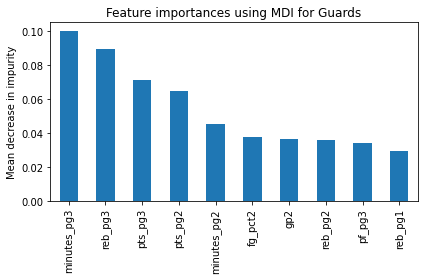

In [366]:
importances = rf_guard_gs.feature_importances_

feature_names = X_df.columns.to_list()

forest_importances = pd.DataFrame(pd.Series(importances, index=feature_names))
forest_importances.columns = ['importances']

forest_importances = forest_importances.sort_values(by = 'importances', ascending = False)


# filter to only 10 most important variables when plotting


fig, ax = plt.subplots()
forest_importances.head(10).plot.bar(ax=ax, legend = None)
ax.set_title("Feature importances using MDI for Guards")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


#### Confusion Matrix for Guards

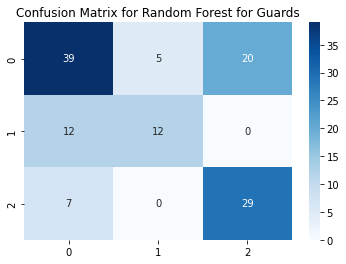

In [207]:
cm_guard = confusion_matrix(clust_te_guard, rf_pred_guard_gs)


ax = sns.heatmap(cm_guard, annot=True, fmt="d", cmap="Blues")
ax.set_title("Confusion Matrix for Random Forest for Guards");

## 8. Random Forest - Forward

#### RF Grid Search

In [216]:
param_grid = {
    'n_estimators': [20, 30, 40, 50, 60, 70],
    'criterion': ['entropy', 'gini'],
    'min_samples_split':[2,4,6,8,10,12,14,16,18,20],
}

# Create a random forest classifier
rf_forw_gs = RandomForestClassifier(random_state = 5)

# Use grid search to find the best hyperparameters
grid_forw = GridSearchCV(rf_forw_gs, param_grid, cv=5, scoring='accuracy')

# Fit the grid search object to the data
grid_forw.fit(pre_tr_forw, clust_tr_forw)
grid_forw.best_params_

{'criterion': 'gini', 'min_samples_split': 4, 'n_estimators': 50}

#### Fit RF using the recommended hyperparameters

In [345]:
rf_forw_gs = RandomForestClassifier(random_state = 5, n_estimators=50, max_features="sqrt", 
                                 criterion = "gini" ,min_samples_split = 4)
rf_forw_gs.fit(pre_tr_forw, clust_tr_forw)
rf_pred_forw_gs = rf_forw_gs.predict(pre_te_forw)
accuracy_score(rf_pred_forw_gs, clust_te_forw)

0.6310160427807486

#### Feature importance of RF for Forwards

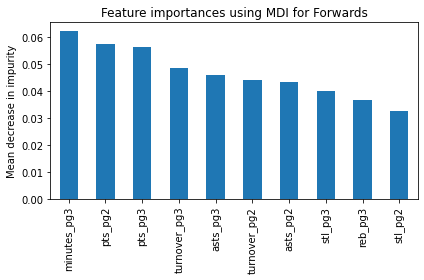

In [367]:
#import matplotlib.pyplot as plt
importances = rf_forw_gs.feature_importances_

feature_names = X_df.columns.to_list()

forest_importances = pd.DataFrame(pd.Series(importances, index=feature_names))
forest_importances.columns = ['importances']

forest_importances = forest_importances.sort_values(by = 'importances', ascending = False)


# filter to only 10 most important variables when plotting


fig, ax = plt.subplots()
forest_importances.head(10).plot.bar(ax=ax, legend = None)
ax.set_title("Feature importances using MDI for Forwards")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


#### Confusion Matrix of RF for Forwards

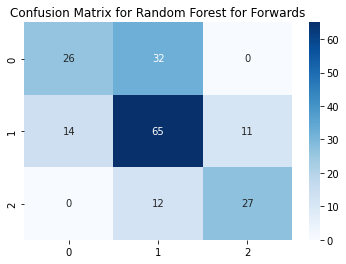

In [368]:
cm_forw = confusion_matrix(clust_te_forw, rf_pred_forw_gs)


ax = sns.heatmap(cm_forw, annot=True, fmt="d", cmap="Blues")
ax.set_title("Confusion Matrix for Random Forest for Forwards");